In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model

In [2]:
img_height, img_width = (224, 224)
batch_size = 32

train_data_dir = r"chest_xray/train"
valid_data_dir = r"chest_xray/val"
test_data_dir = r"chest_xray/test"


In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                shear_range=0.2,
                zoom_range = 0.2,
                horizontal_flip=True,
                validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training')

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation')

Found 3130 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode="categorical")

Found 624 images belonging to 2 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [6]:
train_generator.num_classes

2

In [7]:
base_model = ResNet50(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_generator, epochs=10)

Epoch 1/10
98/98 [==============================] - 359s 4s/step - loss: 0.3383 - accuracy: 0.9169
Epoch 2/10
98/98 [==============================] - 323s 3s/step - loss: 0.1296 - accuracy: 0.9489
Epoch 3/10
98/98 [==============================] - 344s 3s/step - loss: 0.0895 - accuracy: 0.9665
Epoch 4/10
98/98 [==============================] - 365s 4s/step - loss: 0.1059 - accuracy: 0.9633
Epoch 5/10
98/98 [==============================] - 313s 3s/step - loss: 0.0812 - accuracy: 0.9700
Epoch 6/10
98/98 [==============================] - 317s 3s/step - loss: 0.0806 - accuracy: 0.9703
Epoch 7/10
98/98 [==============================] - 307s 3s/step - loss: 0.0999 - accuracy: 0.9617
Epoch 8/10
98/98 [==============================] - 309s 3s/step - loss: 0.0896 - accuracy: 0.9649
Epoch 9/10
98/98 [==============================] - 309s 3s/step - loss: 0.0798 - accuracy: 0.9684
Epoch 10/10
98/98 [==============================] - 330s 3s/step - loss: 0.0666 - accuracy: 0.9770


In [8]:
model.save('Resnet50_Classification.h5')

c:\python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\ntest accuracy: ', test_acc)

624/624 - 125s - loss: 0.3713 - accuracy: 0.8766

test accuracy:  0.8766025900840759


In [10]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
model = tf.keras.models.load_model('Resnet50_Classification.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

In [12]:
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act] 

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

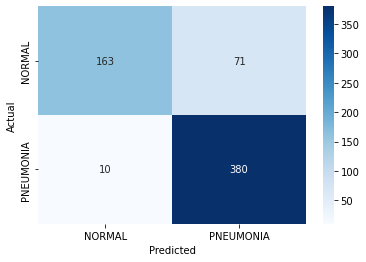

test accuracy : 87.01923076923077


In [13]:
sn.heatmap(confusion_matrix, cmap='Blues',annot=True, fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))